In [1]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
# import constants_sf as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = [2019, 2020, 2023]
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
# shipment_load_attr = 'tons_' + str(analysis_year)
# shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

plot_dir = 'plots_pandemic/'


In [2]:
#load FAF data
# print(c.cfs_distribution_file)
faf_data = read_csv('Validation/' + 'FAF5.6.1.csv', sep = ',')
#load parameters
sctg_group_lookup = read_csv('SynthFirm_parameters/' + 'SCTG_Groups_revised.csv', sep = ',')
cfs_faf_lookup = read_csv('SynthFirm_parameters/' + 'CFS_FAF_LOOKUP.csv', sep = ',')
# sctg_definition = read_csv('SynthFirm_parameters/' + 'SCTG_definition.csv', sep = ',')
sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')

trade_type_id = 1 # domestic only
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id]
faf_data_domestic.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,5.327137,6.342501,7.763605,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live)
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,72.493059,82.113979,96.869428,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live)
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.533539,0.564126,0.638719,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live)
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.018065,3.155784,3.394250,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live)
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.863748,1.969298,2.141527,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live)


In [3]:
# calculate production from FAF
production_by_sctg = None
faf_name_lookup = cfs_faf_lookup[['FAF', 'SHORTNAME']]
value_attrs = []
for year in analysis_year:
    shipment_load_attr = 'tons_' + str(year)
    shipment_value_attr = 'value_' + str(year)
    value_attrs.append(shipment_load_attr)
    value_attrs.append(shipment_value_attr)
    production_by_sctg_year = \
    faf_data_domestic.groupby(['dms_orig', 'SCTG_Name'])[[shipment_value_attr, shipment_load_attr]].sum()
    
    production_by_sctg_year = production_by_sctg_year.reset_index()
    production_by_sctg_year.rename(columns = {'dms_orig': 'FAF'}, inplace = True)
    if production_by_sctg is None:
        production_by_sctg = production_by_sctg_year
    else:
        production_by_sctg = pd.merge(production_by_sctg,
                                      production_by_sctg_year,
                                      on = ['FAF', 'SCTG_Name'],
                                      how = 'left')
production_by_sctg_total = production_by_sctg.groupby('FAF')[value_attrs].sum()
production_by_sctg_total = production_by_sctg_total.reset_index()
production_by_sctg_total.loc[:, 'SCTG_Name'] = 'total'

production_by_sctg = pd.concat([production_by_sctg,
                                production_by_sctg_total])

production_by_sctg = pd.merge(production_by_sctg, faf_name_lookup,
                              on = ['FAF'],  how = 'left')
production_by_sctg.loc[:, 'ton_change_disruption'] = \
production_by_sctg.loc[:, 'tons_2020'] - \
production_by_sctg.loc[:, 'tons_2019']

production_by_sctg.loc[:, 'value_change_disruption'] = \
production_by_sctg.loc[:, 'value_2020'] - \
production_by_sctg.loc[:, 'value_2019']

production_by_sctg.loc[:, 'ton_change_recovery'] = \
production_by_sctg.loc[:, 'tons_2023'] - \
production_by_sctg.loc[:, 'tons_2019']

production_by_sctg.loc[:, 'value_change_recovery'] = \
production_by_sctg.loc[:, 'value_2023'] - \
production_by_sctg.loc[:, 'value_2019']
production_by_sctg.head(5)
production_by_sctg.to_csv(os.path.join(plot_dir, 'faf_production_by_zone.csv'),
                          index = False)

In [4]:
# calculate consumption from FAF
consumption_by_sctg = None
faf_name_lookup = cfs_faf_lookup[['FAF', 'SHORTNAME']]
value_attrs = []
for year in analysis_year:
    shipment_load_attr = 'tons_' + str(year)
    shipment_value_attr = 'value_' + str(year)
    value_attrs.append(shipment_load_attr)
    value_attrs.append(shipment_value_attr)
    consumption_by_sctg_year = \
    faf_data_domestic.groupby(['dms_dest', 'SCTG_Name'])[[shipment_value_attr, shipment_load_attr]].sum()
    
    consumption_by_sctg_year = consumption_by_sctg_year.reset_index()
    consumption_by_sctg_year.rename(columns = {'dms_dest': 'FAF'}, inplace = True)
    if consumption_by_sctg is None:
        consumption_by_sctg = consumption_by_sctg_year
    else:
        consumption_by_sctg = pd.merge(consumption_by_sctg,
                                      consumption_by_sctg_year,
                                      on = ['FAF', 'SCTG_Name'],
                                      how = 'left')
consumption_by_sctg_total = consumption_by_sctg.groupby('FAF')[value_attrs].sum()
consumption_by_sctg_total = consumption_by_sctg_total.reset_index()
consumption_by_sctg_total.loc[:, 'SCTG_Name'] = 'total'

consumption_by_sctg = pd.concat([consumption_by_sctg,
                                consumption_by_sctg_total])

consumption_by_sctg = pd.merge(consumption_by_sctg, faf_name_lookup,
                              on = ['FAF'],  how = 'left')
consumption_by_sctg.loc[:, 'ton_change_disruption'] = \
consumption_by_sctg.loc[:, 'tons_2020'] - \
consumption_by_sctg.loc[:, 'tons_2019']

consumption_by_sctg.loc[:, 'value_change_disruption'] = \
consumption_by_sctg.loc[:, 'value_2020'] - \
consumption_by_sctg.loc[:, 'value_2019']

consumption_by_sctg.loc[:, 'ton_change_recovery'] = \
consumption_by_sctg.loc[:, 'tons_2023'] - \
consumption_by_sctg.loc[:, 'tons_2019']

consumption_by_sctg.loc[:, 'value_change_recovery'] = \
consumption_by_sctg.loc[:, 'value_2023'] - \
consumption_by_sctg.loc[:, 'value_2019']

consumption_by_sctg.to_csv(os.path.join(plot_dir, 'faf_consumption_by_zone.csv'),
                          index = False)
consumption_by_sctg.head(5)

,FAF,SCTG_Name,value_2019,tons_2019,value_2020,tons_2020,value_2023,tons_2023,SHORTNAME,ton_change_disruption,value_change_disruption,ton_change_recovery,value_change_recovery
0,11,bulk,6268.433999,51608.611705,5667.548005,46629.047068,5941.219083,47523.177797,Birmingham,-4979.564637,-600.885994,-4085.433908,-327.214916
1,11,fuel_fert,9857.242581,30800.615724,9541.848511,30971.041435,10159.880559,32749.700624,Birmingham,170.425711,-315.394070,1949.084900,302.637978
2,11,interm_food,6763.923996,5210.091901,6974.515192,5342.411856,6901.697855,5314.015691,Birmingham,132.319955,210.591196,103.923790,137.773859
3,11,mfr_goods,52629.933054,13115.493733,48619.904842,12409.294327,51379.965076,11987.016606,Birmingham,-706.199406,-4010.028212,-1128.477127,-1249.967978
4,11,other,5318.847861,5079.018193,5283.443676,5074.214190,5238.008270,5168.740504,Birmingham,-4.804003,-35.404185,89.722311,-80.839591


Projected CRS: EPSG:3857


<Axes: >

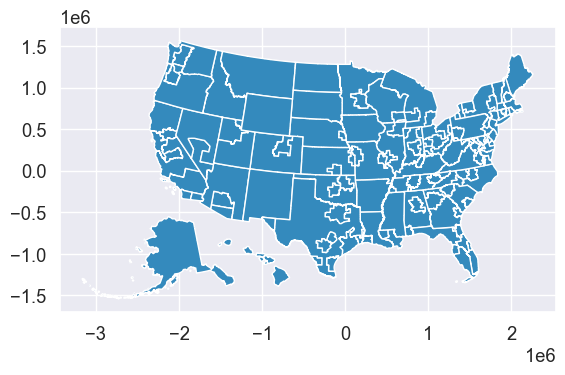

In [5]:
# plot changes
from pygris.utils import shift_geometry
faf5_zones = gps.read_file(os.path.join('Validation', 'FAF5Zones.geojson'))
faf5_zones = faf5_zones.to_crs(epsg=3857)  # Using EPSG:3857 which is a common equal area projection for Europe and works well for global data

# Print projected CRS
print("Projected CRS:", faf5_zones.crs)

# Calculate area in square meters
faf5_zones['area'] = faf5_zones.area/1000000 # in km2
faf5_zones = faf5_zones.to_crs(epsg=4269)
faf5_zones = shift_geometry(faf5_zones)
faf5_zones.plot()

plot results for bulk


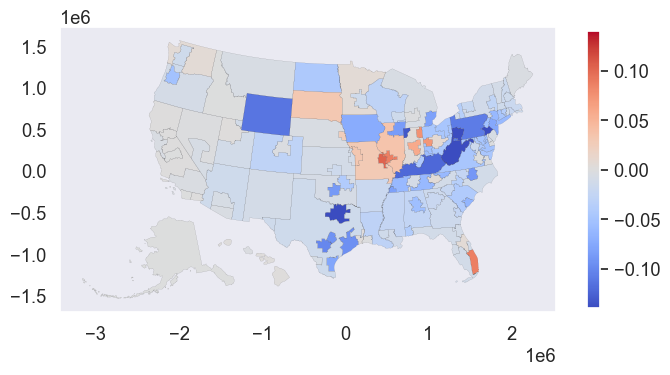

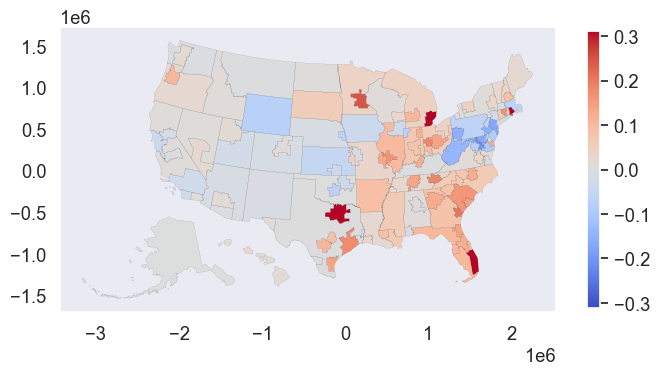

plot results for fuel_fert


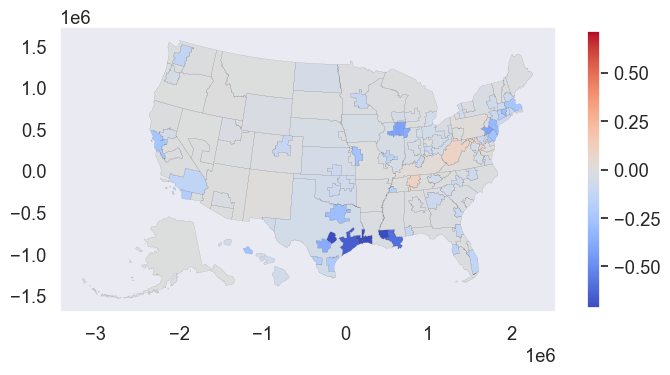

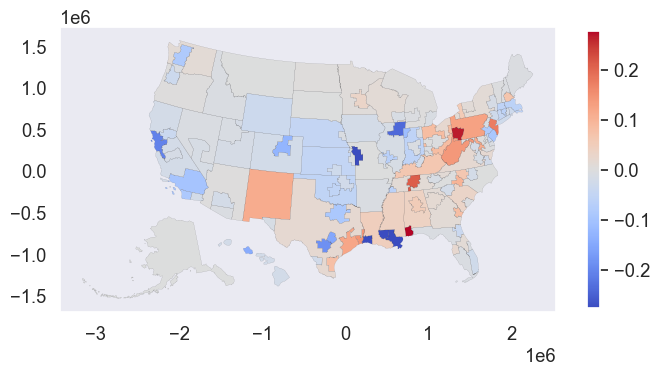

plot results for interm_food


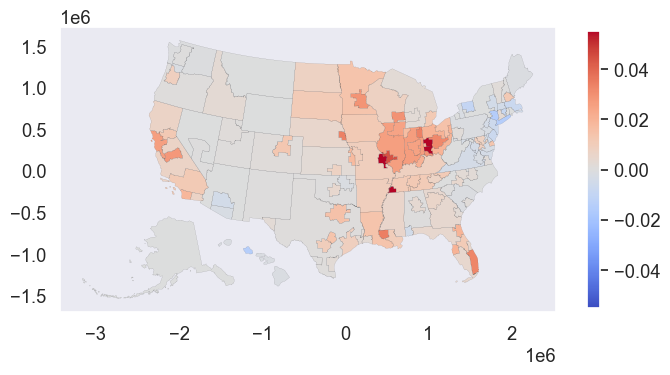

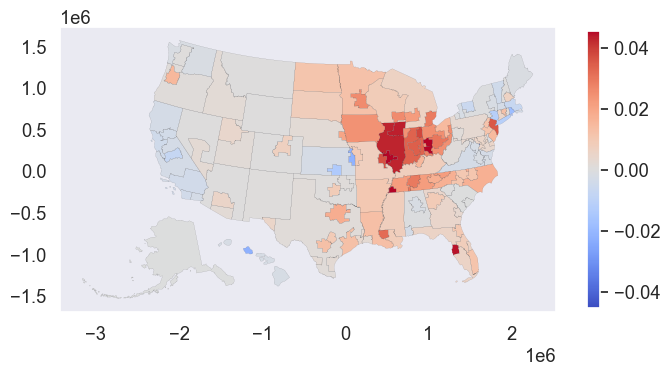

plot results for mfr_goods


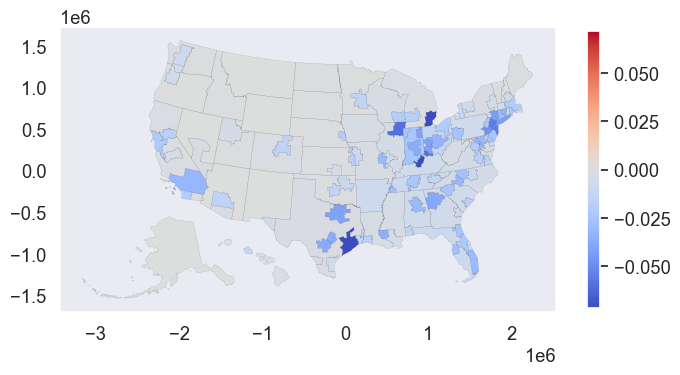

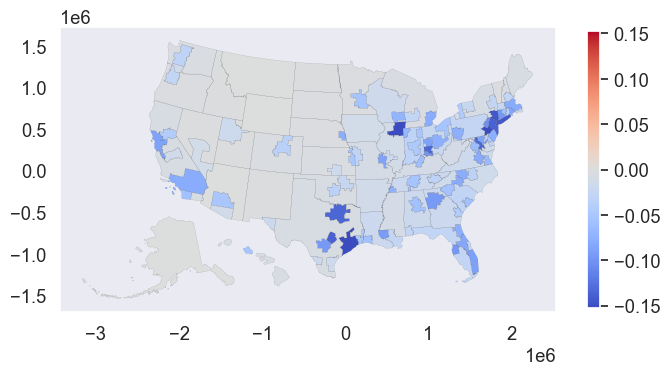

plot results for other


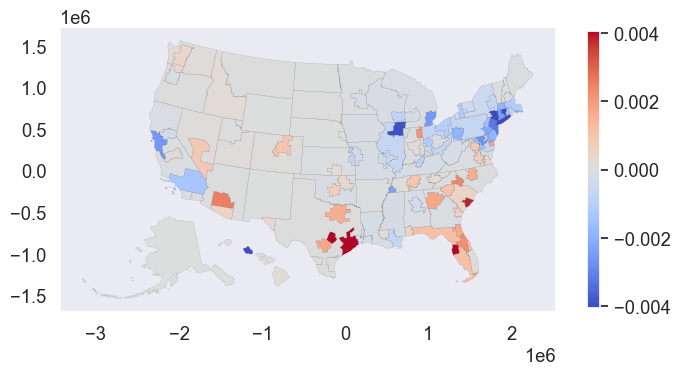

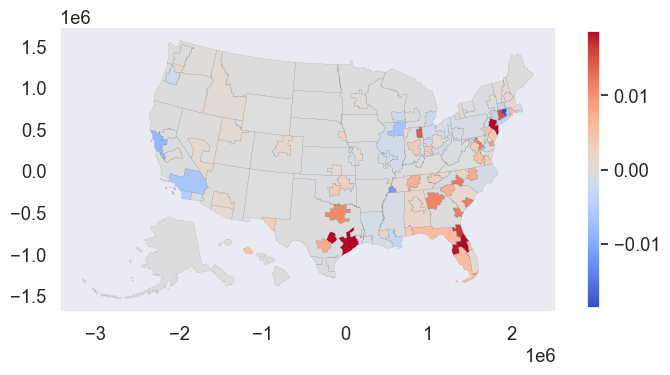

plot results for total


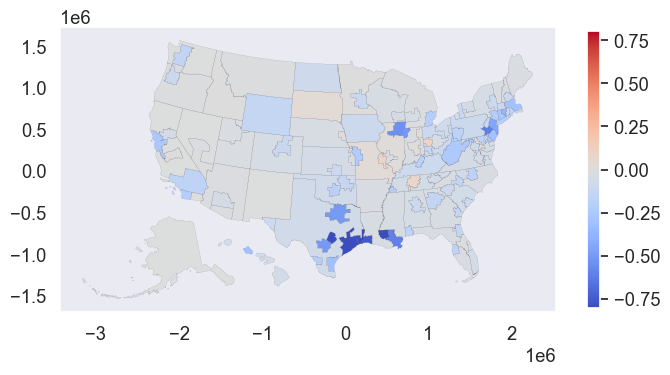

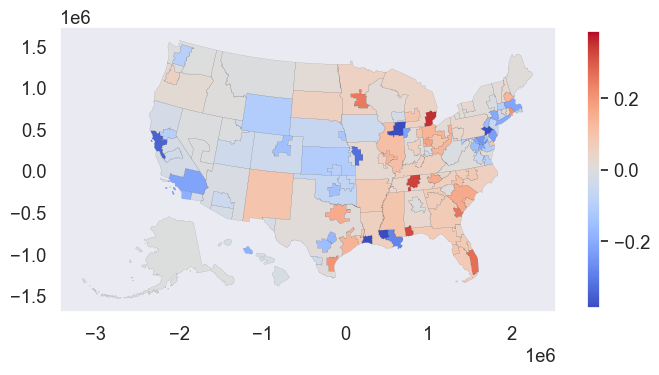

In [9]:
# changes in production per area
faf5_zones['FAF'] = faf5_zones['FAF'].astype(int)
sctg_groups = production_by_sctg.SCTG_Name.unique()
for sctg in sctg_groups:
    print('plot results for ' + sctg)
    production_by_sctg_sel = \
    production_by_sctg.loc[production_by_sctg['SCTG_Name'] == sctg]
    faf5_zones_with_prod = faf5_zones.merge(production_by_sctg_sel, on = 'FAF',
                                           how = 'left')

    # disruption
    
    faf5_zones_with_prod.loc[:, 'ton_change_disruption'] =\
    faf5_zones_with_prod.loc[:, 'ton_change_disruption'] / \
    faf5_zones_with_prod.loc[:, 'area']
    
    upper_bound = faf5_zones_with_prod['ton_change_disruption'].quantile(0.975)
    lower_bound = faf5_zones_with_prod['ton_change_disruption'].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound

    
    ax = faf5_zones_with_prod.plot(figsize = (8,6), column = 'ton_change_disruption', 
                            legend=True,
                                cmap='coolwarm', 
                              vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none')
    faf5_zones.plot(ax = ax, facecolor='None', edgecolor='k', linewidth = 0.05)

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'faf_delta_production_disruption_' + sctg + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()

    # recovery
    faf5_zones_with_prod.loc[:, 'ton_change_recovery'] =\
    faf5_zones_with_prod.loc[:, 'ton_change_recovery'] / \
    faf5_zones_with_prod.loc[:, 'area']
    
    upper_bound = faf5_zones_with_prod['ton_change_recovery'].quantile(0.975)
    lower_bound = faf5_zones_with_prod['ton_change_recovery'].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound
    ax = faf5_zones_with_prod.plot(figsize = (8,6), column = 'ton_change_recovery', 
                            legend=True,
                                cmap='coolwarm', 
                              vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none')
    faf5_zones.plot(ax = ax, facecolor='None', edgecolor='k', linewidth = 0.05)

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'faf_delta_production_recovery_' + sctg + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()

plot results for bulk


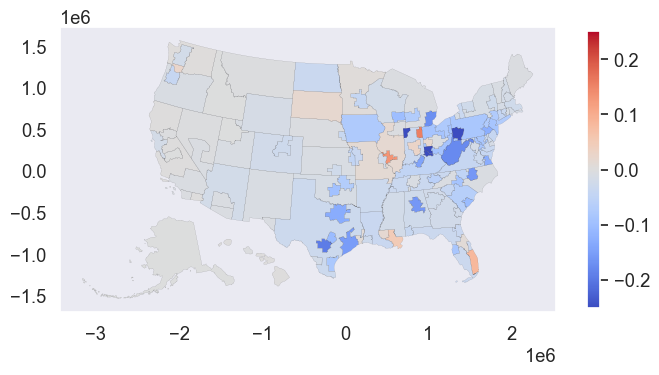

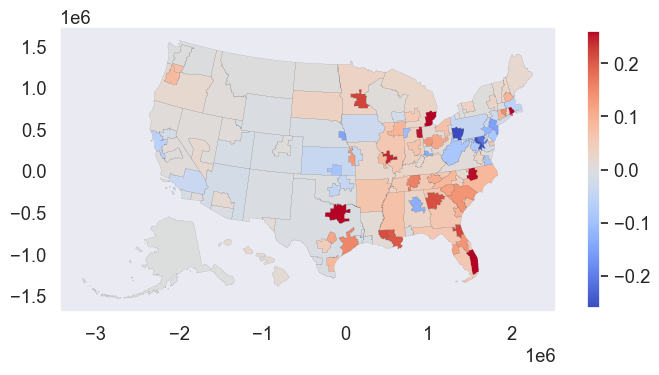

plot results for fuel_fert


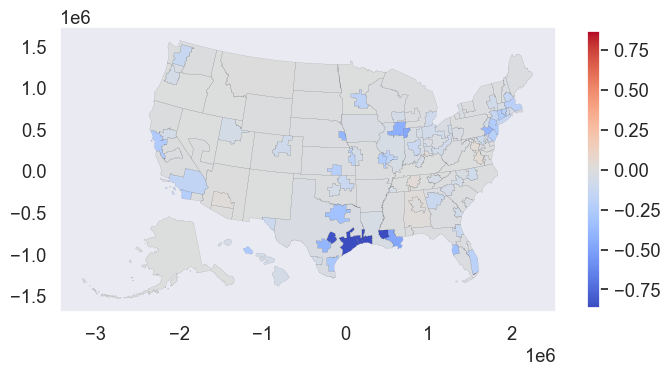

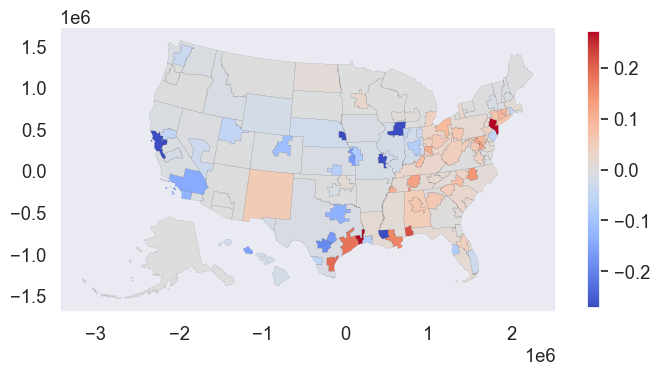

plot results for interm_food


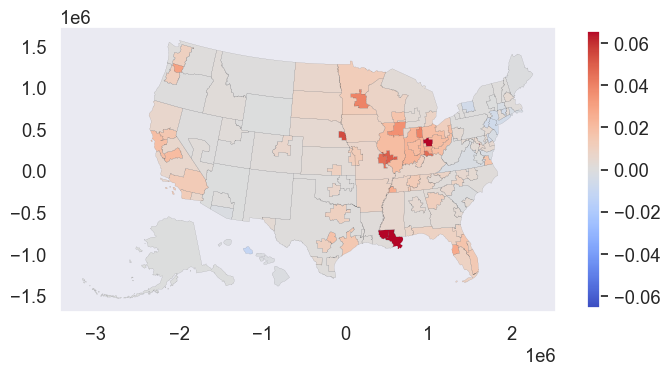

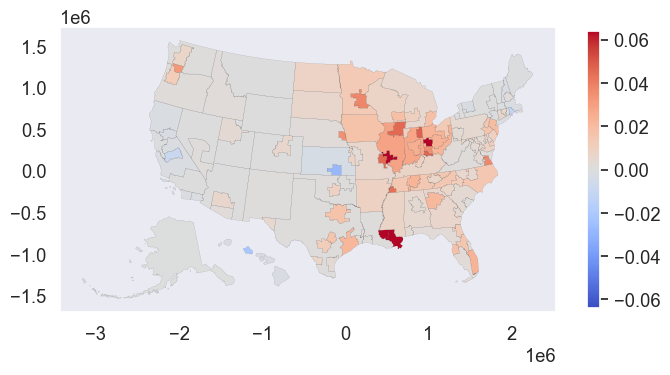

plot results for mfr_goods


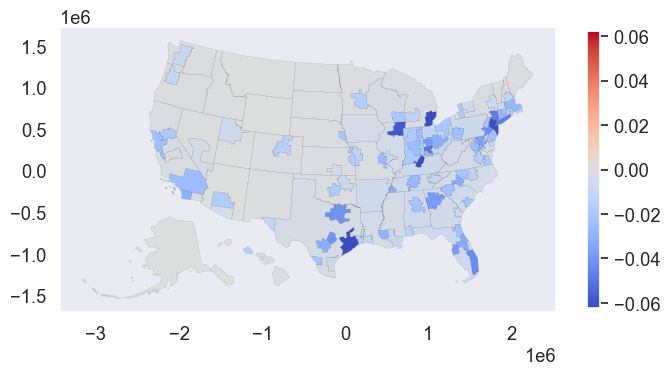

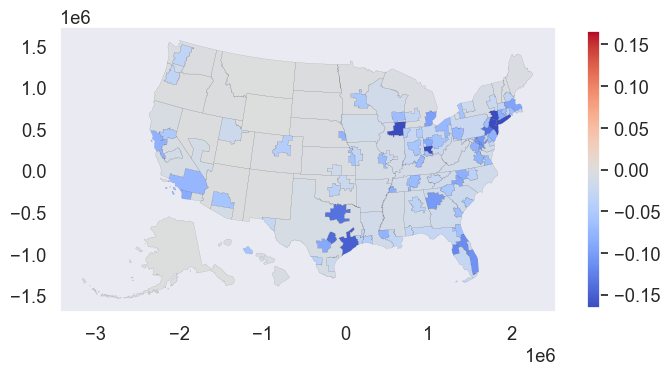

plot results for other


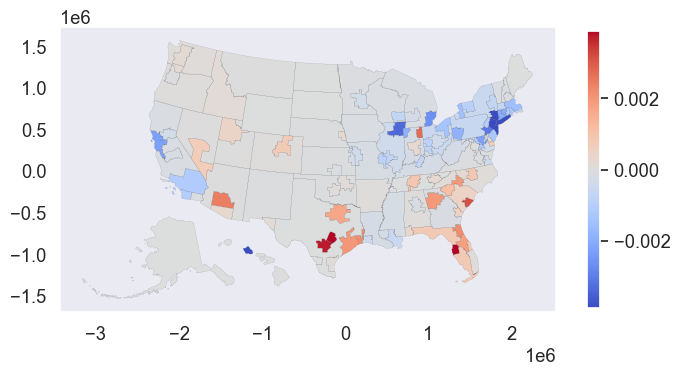

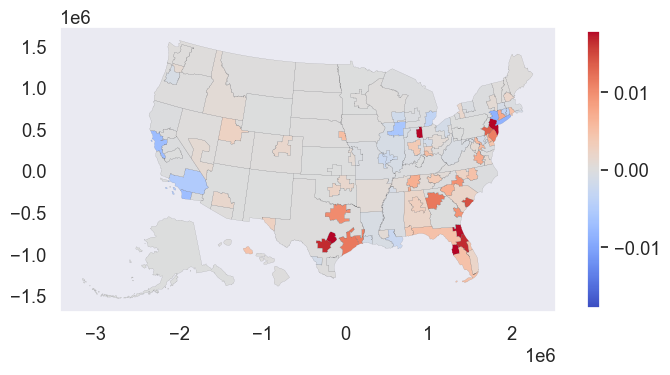

plot results for total


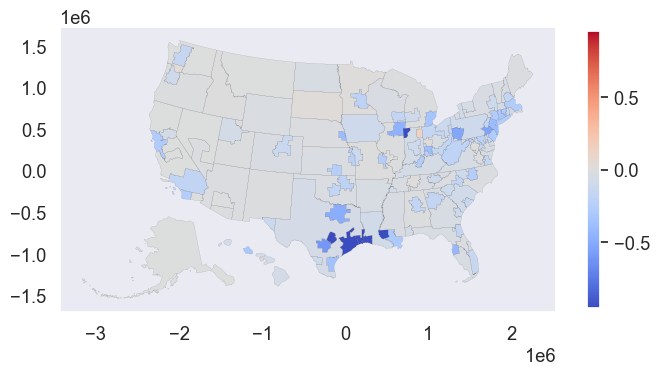

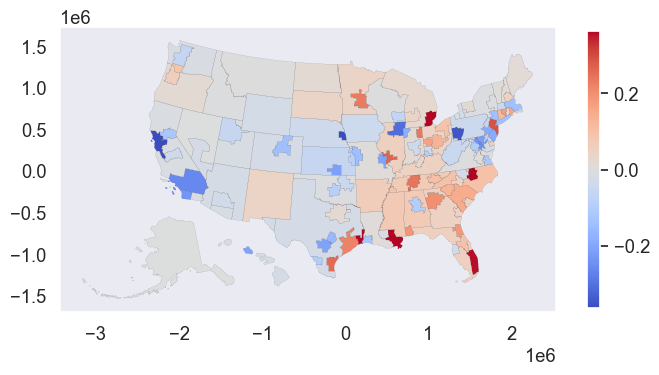

In [10]:
# changes in consumption per area

sctg_groups = consumption_by_sctg.SCTG_Name.unique()
for sctg in sctg_groups:
    print('plot results for ' + sctg)
    consumption_by_sctg_sel = \
    consumption_by_sctg.loc[consumption_by_sctg['SCTG_Name'] == sctg]
    faf5_zones_with_cons = faf5_zones.merge(consumption_by_sctg_sel, on = 'FAF',
                                           how = 'left')

    # disruption
    
    faf5_zones_with_cons.loc[:, 'ton_change_disruption'] =\
    faf5_zones_with_cons.loc[:, 'ton_change_disruption'] / \
    faf5_zones_with_cons.loc[:, 'area']
    
    upper_bound = faf5_zones_with_cons['ton_change_disruption'].quantile(0.975)
    lower_bound = faf5_zones_with_cons['ton_change_disruption'].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound

    
    ax = faf5_zones_with_cons.plot(figsize = (8,6), column = 'ton_change_disruption', 
                            legend=True,
                                cmap='coolwarm', 
                              vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none')
    faf5_zones.plot(ax = ax, facecolor='None', edgecolor='k', linewidth = 0.05)

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'faf_delta_consumption_disruption_' + sctg + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()

    # recovery
    faf5_zones_with_cons.loc[:, 'ton_change_recovery'] =\
    faf5_zones_with_cons.loc[:, 'ton_change_recovery'] / \
    faf5_zones_with_cons.loc[:, 'area']
    
    upper_bound = faf5_zones_with_cons['ton_change_recovery'].quantile(0.975)
    lower_bound = faf5_zones_with_cons['ton_change_recovery'].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound
    ax = faf5_zones_with_cons.plot(figsize = (8,6), column = 'ton_change_recovery', 
                            legend=True,
                                cmap='coolwarm', 
                              vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none')
    faf5_zones.plot(ax = ax, facecolor='None', edgecolor='k', linewidth = 0.05)

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'faf_delta_consumption_recovery_' + sctg + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()